In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Loan%20Eligibility%20Prediction.csv')
df

,Customer_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,569,Female,No,0,Graduate,No,2378,0.0,9,360,1,Urban,N
1,15,Male,Yes,2,Graduate,No,1299,1086.0,17,120,1,Urban,Y
2,95,Male,No,0,Not Graduate,No,3620,0.0,25,120,1,Semiurban,Y
3,134,Male,Yes,0,Graduate,Yes,3459,0.0,25,120,1,Semiurban,Y
4,556,Male,Yes,1,Graduate,No,5468,1032.0,26,360,1,Semiurban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,480,Male,Yes,2,Graduate,No,2947,1603.0,10,360,1,Urban,N
610,525,Male,No,0,Graduate,No,4680,2087.0,15,360,1,Semiurban,N
611,551,Male,Yes,2,Graduate,Yes,6633,0.0,25,360,0,Rural,N
612,552,Male,Yes,1,Not Graduate,No,2492,2375.0,30,360,1,Rural,Y


##предобработка датасета

In [2]:
# обращаем столбцы типа object в бинарные
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

data = df.copy()
for col in data.columns:
  if data[col].dtype == 'object':
    data[col] = encoder.fit_transform(data[col])
data.head()
data

,Customer_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,569,0,0,0,0,0,2378,0.0,9,360,1,2,0
1,15,1,1,2,0,0,1299,1086.0,17,120,1,2,1
2,95,1,0,0,1,0,3620,0.0,25,120,1,1,1
3,134,1,1,0,0,1,3459,0.0,25,120,1,1,1
4,556,1,1,1,0,0,5468,1032.0,26,360,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,480,1,1,2,0,0,2947,1603.0,10,360,1,2,0
610,525,1,0,0,0,0,4680,2087.0,15,360,1,1,0
611,551,1,1,2,0,1,6633,0.0,25,360,0,0,0
612,552,1,1,1,1,0,2492,2375.0,30,360,1,0,1


In [3]:
#чистим выборку от выбросов по целевой переменной
clean_data = data[(data['Loan_Status']>=data['Loan_Status'].quantile(0.05))&(data['Loan_Status']<=data['Loan_Status'].quantile(0.95))]


##стратифицированное разделение датасета на обучающую и тестовую выборку

In [16]:
cld=clean_data
features = ['Applicant_Income', 'Loan_Amount']
target = ['Loan_Status']

x_train, x_test, y_train, y_test = train_test_split(cld[features], cld[target], test_size=0.25, random_state = 28, stratify=cld[target])


##обучение модели Decision Tree на обучающей выборке

In [17]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(x_train,y_train)

DecisionTreeClassifier()

##построение решающего дерева

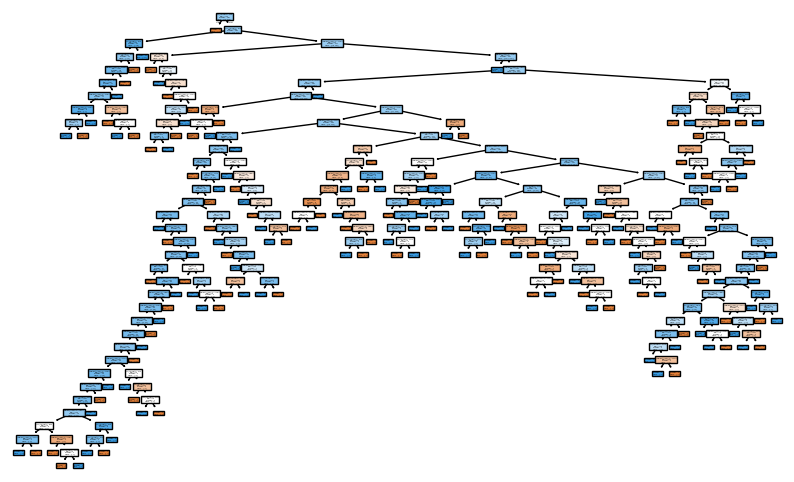

In [18]:

plt.figure(figsize=(10, 6))
plot_tree(decisionTree, feature_names=['Applicant_Income', 'Loan_Amount'], filled=True);

##подбор гиперпараметра с помощью GridSearch и взвешенного разделения по классам

In [20]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'criterion': ('gini','entropy','log_loss'),
    'max_depth': range(1,10),
    'min_samples_split': range(5,15),
    'min_samples_leaf':range(5,15)
}

decisionTree = DecisionTreeClassifier(class_weight='balanced')
clf = GridSearchCV(decisionTree, parameters, scoring = 'f1_weighted')
clf.fit(x_train, y_train)
pd.DataFrame(clf.cv_results_).sort_values(by = 'rank_test_score',ascending = True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
519,0.005816,0.000282,0.009767,0.000137,gini,6,6,14,"{'criterion': 'gini', 'max_depth': 6, 'min_sam...",0.402768,0.64657,0.617255,0.634731,0.640012,0.588267,0.093259,1
518,0.005713,0.000254,0.011198,0.001439,gini,6,6,13,"{'criterion': 'gini', 'max_depth': 6, 'min_sam...",0.402768,0.64657,0.617255,0.634731,0.640012,0.588267,0.093259,1
514,0.007214,0.001226,0.012056,0.001029,gini,6,6,9,"{'criterion': 'gini', 'max_depth': 6, 'min_sam...",0.402768,0.64657,0.617255,0.626127,0.640012,0.586546,0.092462,3
515,0.006432,0.000843,0.011190,0.000851,gini,6,6,10,"{'criterion': 'gini', 'max_depth': 6, 'min_sam...",0.402768,0.64657,0.617255,0.626127,0.640012,0.586546,0.092462,3
516,0.006280,0.001080,0.010021,0.000377,gini,6,6,11,"{'criterion': 'gini', 'max_depth': 6, 'min_sam...",0.402768,0.64657,0.617255,0.626127,0.640012,0.586546,0.092462,3


In [21]:
clf.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=6,
                       min_samples_split=13)

##построение решающего дерева

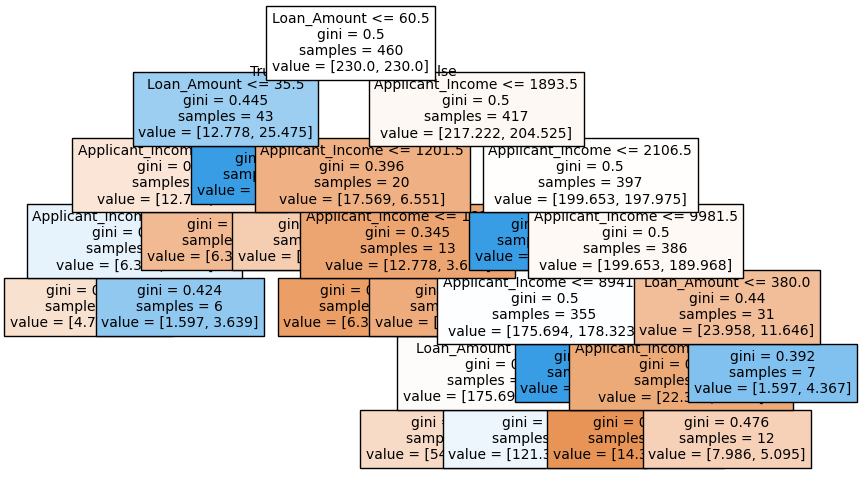

In [22]:
dt = clf.best_estimator_
dt.fit(x_train, y_train)

plt.figure(figsize=(10, 6))
plot_tree(dt,filled = True, feature_names =['Applicant_Income', 'Loan_Amount'], fontsize = 10)
plt.show()

вывод: подбор параметра минимизировал количество разделений. При этом разделение на три конечные группы не показывает, при каких условиях кредит выдадут точно

##визуализация разделяющих прямых

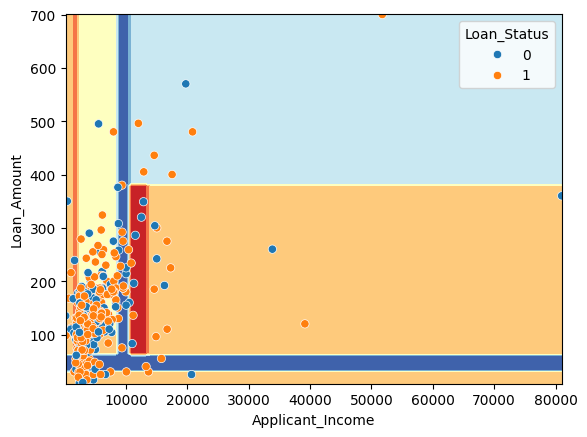

In [23]:
fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
      clf,
      x_train,
      cmap=plt.cm.RdYlBu,
      response_method = "predict_proba",
      ax=ax,
      xlabel = x_train.columns[0],
      ylabel = x_train.columns[1],
)

sns.scatterplot(data = pd.concat([x_train, y_train], axis = 1), x = 'Applicant_Income', y = 'Loan_Amount', hue = 'Loan_Status')

plt.show()

линейное разделение не разделяет показания на области по классам таргета. Во всех областях показания таргета обоих классов.  Наблюдается сильное смешение(наложение) показаний разных классов особенно в области , где доход не превышает 10000, а сумма кредита до 300. Скорее всего данные в этой области сильно коррелированы и между ними наблюдается нелинейная зависимость.

##предсказания целевой переменной для тестовой выборки

In [24]:
y_pred = dt.predict(x_test)

##матрица ошибок и метрики качества

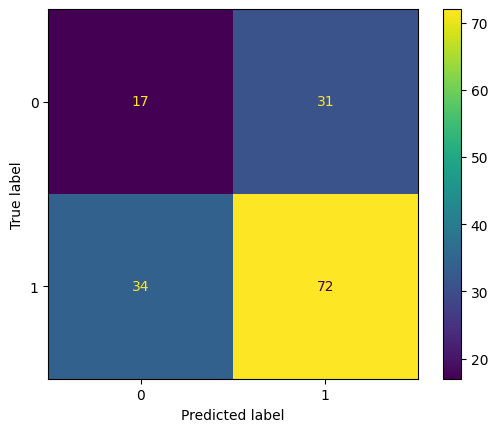

Accuracy: 0.577922077922078
Precision: 0.6990291262135923
Recall: 0.6792452830188679
F1-score: 0.6889952153110048


In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred))

Очень невысокий accuracy,т.е. модель почти не отличается от предсказания с вероятностью 0.5, модель чаще предсказывает класс 1 и часто допускает ошибки первого и второго рода.

In [15]:
y_train.value_counts()

,count
Loan_Status,
1,313
0,147
